In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# Mask R-CNN - Train on Jalbert Dataset


import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
from config import Config
import utils
import model as modellib
import visualize
from model import log

%matplotlib inline 

Using TensorFlow backend.


ppm conversion: 100%|█| 44/44 [00:00<00:00, 107797.53it/s]


Loading from precedent scan
Image Count: 364
Class Count: 2
  0. BG                                                
  1. label                                             
Train
Image Count: 241
Class Count: 2
  0. BG                                                
  1. label                                             
Val
Image Count: 122
Class Count: 2
  0. BG                                                
  1. label                                             

Configurations:
BACKBONE_SHAPES                [[128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]
 [  8   8]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 4
IMAGE_MAX_DIM                  512
IMAGE_MIN_DIM                  512
IMAGE_PADDING                  True
IMAGE_SHAPE  

/dds/miniconda/envs/dds/lib/python3.5/site-packages/matplotlib/axes/_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-0.5, right=-0.5
  'left=%s, right=%s') % (left, right))
/dds/miniconda/envs/dds/lib/python3.5/site-packages/matplotlib/axes/_base.py:3193: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  'bottom=%s, top=%s') % (bottom, top))


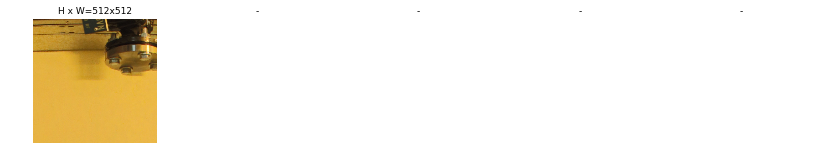

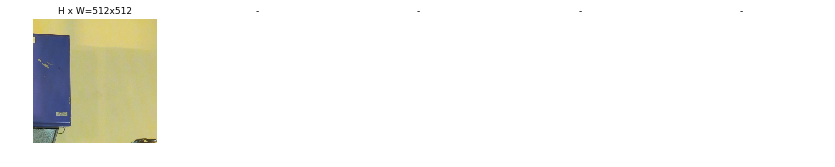

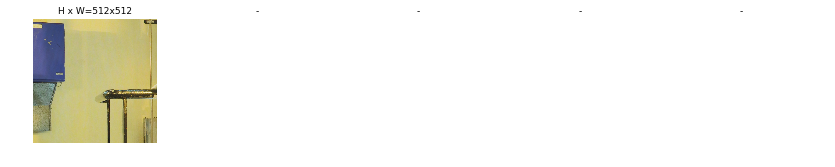

In [2]:
# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

## Notebook Preferences

def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

import jalbert
config = jalbert.jalbertConfig()


train=True


dim = 512

data_folder = "/dds/work/workspace/data_ja/"
groundtruth_path='/dds/work/workspace/data_ja/RF-CAT1-v1.0.csv'

scales = [0.8, 1., 1.25]

#splits = ["all"]
# splits = ["train"]
# splits = ["test"]
# splits = ["test","train"]


dataset = jalbert.jalbertDataset()
dataset.load_jalbert(dim, data_folder,groundtruth_path, scales)#, force_new_dataset=True)
dataset.prepare()
print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

nb_img = dataset.num_images
split_train = slice(1,2*nb_img//3)
split_val = slice(2*nb_img//3,nb_img)

dataset_train = jalbert.copydataset(dataset,split_train)
dataset_val = jalbert.copydataset(dataset,split_val)

print("Train")
print("Image Count: {}".format(len(dataset_train.image_ids)))
print("Class Count: {}".format(dataset_train.num_classes))
for i, info in enumerate(dataset_train.class_info):
    print("{:3}. {:50}".format(i, info['name']))

print("Val")
print("Image Count: {}".format(len(dataset_val.image_ids)))
print("Class Count: {}".format(dataset_val.num_classes))
for i, info in enumerate(dataset_val.class_info):
    print("{:3}. {:50}".format(i, info['name']))

#config.IMAGES_PER_GPU = 2
config.display()


# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 3)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [3]:
dataset_val.image_info

[{'id': 0, 'path': None, 'source': 'jalbert'},
 {'id': 1, 'path': None, 'source': 'jalbert'},
 {'id': 2, 'path': None, 'source': 'jalbert'},
 {'id': 3, 'path': None, 'source': 'jalbert'},
 {'id': 4, 'path': None, 'source': 'jalbert'},
 {'id': 5, 'path': None, 'source': 'jalbert'},
 {'id': 6, 'path': None, 'source': 'jalbert'},
 {'id': 7, 'path': None, 'source': 'jalbert'},
 {'id': 8, 'path': None, 'source': 'jalbert'},
 {'id': 9, 'path': None, 'source': 'jalbert'},
 {'id': 10, 'path': None, 'source': 'jalbert'},
 {'id': 11, 'path': None, 'source': 'jalbert'},
 {'id': 12, 'path': None, 'source': 'jalbert'},
 {'id': 13, 'path': None, 'source': 'jalbert'},
 {'id': 14, 'path': None, 'source': 'jalbert'},
 {'id': 15, 'path': None, 'source': 'jalbert'},
 {'id': 16, 'path': None, 'source': 'jalbert'},
 {'id': 17, 'path': None, 'source': 'jalbert'},
 {'id': 18, 'path': None, 'source': 'jalbert'},
 {'id': 19, 'path': None, 'source': 'jalbert'},
 {'id': 20, 'path': None, 'source': 'jalbert'},
 {

In [17]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                      model_dir=MODEL_DIR)


# Which weights to start with?
init_with = "imagenet"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)


# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=3, 
            layers='heads')


# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=20, 
            layers="all")

class InferenceConfig(jalbert.jalbertConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]
#model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes_jalbert_all.h5")

# model_path = '/dds/work/workspace/Mask_RCNN/logs/jalbert20180310T2026/mask_rcnn_jalbert_0005.h5'
# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)


# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
nb_test_images = len(dataset_val.image_ids)
print("testing on "+str(nb_test_images)+" images...")
image_ids = np.random.choice(dataset_val.image_ids, nb_test_images)
APs = []
match_counts = []
pred_counts = []
gt_boxes_counts = []
for image_id in tqdm(image_ids):
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =        utils.compute_ap(gt_bbox, gt_class_id,
                         r["rois"], r["class_ids"], r["scores"])
    
    match_count, pred_count, gt_boxes_count = utils.jg_compute_scores(gt_bbox, gt_class_id,
                         r["rois"], r["class_ids"], r["scores"])
    APs.append(AP)
    match_counts.append(match_count)
    pred_counts.append(pred_count)
    gt_boxes_counts.append(gt_boxes_count)
    
print("mAP: ", np.mean(APs))
print("match_count: ", np.sum(match_counts))
print("pred_count: ", np.sum(pred_counts))
print("gt_boxes_count: ", np.sum(gt_boxes_counts))
print("precision: ", np.sum(match_counts)/np.sum(pred_counts))
print("recall: ", np.sum(match_counts)/np.sum(gt_boxes_counts))
print("Over.")

testing on 26 images...

mAP:  0.269230769231
match_count:  9
pred_count:  19
gt_boxes_count:  31
precision:  0.473684210526
recall:  0.290322580645
Over.
